In [ ]:
import numpy as np
np.random.seed(0)
from scipy import signal
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7, 8.27)})


#### Next, we will be defining 'g' and 'g'' which we'll use to determine the new value for w

In [21]:
def g(x):
  return np.tanh(x)

def g_der(x):
  return 1 - g(x) * g(x)

  

#### We create a function to center the signal by subtracting th mean

In [22]:
def center(X):
  X = np.array(X)

  mean = X.mean(axis=1, keepdims=True)

  return X- mean
  

#### We define a function to whiten the signal using the method describe above

In [23]:
def whitening(X):
  cov = np.cov(X)
  d, E = np.linalg.eigh(cov)
  D = np.diag(d)
  D_inv = np.sqrt(np.linalg.inv(D))
  X_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, X)))
  return X_whiten
  

#### We define a function to update the de - mixing matrix w

In [24]:
def calculate_new_w(w, X):
  w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_der(np.dot(w.T,X)).mean() * w
  w_new /= np.sqrt((w_new ** 2).sum())
  return w_new

#### Finally, we define the main method which calls the preprocessing functions, initializes w to some random set of values and iteratively updates w. Again, convergence can be judged by the fact that an ideal w would be orthogonal, and hence w multiplied by its transpose would be approximately equal to 1. After computing the optimal value of w for each component, we take the dot product of the resulting matrix and the signal x to get the sources.

In [33]:
# from scipy.spatial import distance
def ica(X, iterations, tolerance=1e-5):
  X = center(X)
  X = whitening(X)

  components_nr = X.shape[0]

  W = np.zeros((components_nr, components_nr), dtype=X.dtype)

  for i in range(components_nr):
    w = np.random.rand(components_nr)
    for j in range(iterations):
        w_new = calculate_new_w(w, X)
        if i >= 1:
          w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
        distance = np.abs(np.abs((w * w_new).sum()) - 1)
        w = w_new
        
        if distance < tolerance:
          break
          
          W[i, :] = w

  S = np.dot(W, X)
  return S



### We define a function to plot an compare the original, mixed, and predicted signals.

In [39]:
def plot_mixture_sources_prediction(x, original_sources, S):
  fig = plt.figure()

  plt.subplot(3, 1, 1)
  for x in X:
    plt.plot(x)
  plt.title('mixtures')

  plt.subplot(3, 1, 2)
  for s in original_sources:
    plt.plot(s)
  plt.title('real_sources')

  plt.subplot(3, 1, 3)
  for s in S:
    plt.plot(s)
  plt.title('predicted sources')

  fig.tight_layout()
  plt.show()

### For the sake of the proceeding example, we create a method to artificially mix different sources signals.

In [40]:
def mix_sources(mixtures, apply_noise=False):
  for i in range(len(mixtures)):

    max_val = np.max(mixtures[i])

    if max_val > 1 or np.min(mixtures[i]) < 1:
      
      mixtures[i] = mixtures[i] / (max_val / 2) - 0.5

  X = np.c_[[mix for mix in mixtures]]

  if apply_noise:
    X += 0.02 * np.random.normal(size=X.shape)
  return X

### Then we create 3 signals, each with its own distinct pattern

In [41]:
import numpy as np
import signal
import matplotlib.pyplot as plt
from scipy import signal
from time import time
# import medfilt as mf
import pandas as pd
import numpy as np

In [42]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time) # Sinusoidal
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time) # saw tooth signal

### In the proceeding example, we compute the dot product of the matrix A and the signals to obtain a combination of all three. We then use the independent component analysis to seperate the mixed signal into th eoriginal source signals.

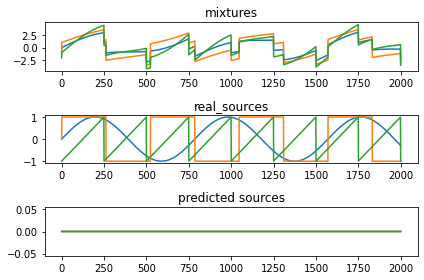

In [43]:
X = np.c_[s1, s2, s3]
A = np.array(([1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=1000)
plot_mixture_sources_prediction(X, [s1, s2, s3], S)


### Next, we have to use ICA decompose a mixture of actual audio tracks and plot the result. If you'd like to try it yourself, you can get the audio samples. 

In [44]:
from google.colab import files
uploaded = files.upload()

Saving mix1.wav to mix1.wav


In [45]:
from google.colab import files
uploaded = files.upload()

Saving mix2.wav to mix2.wav


In [47]:
from google.colab import files
uploaded = files.upload()

Saving source1.wav to source1.wav


In [48]:
from google.colab import files
uploaded = files.upload()

Saving source2.wav to source2.wav


In [52]:
from scipy.io import wavfile

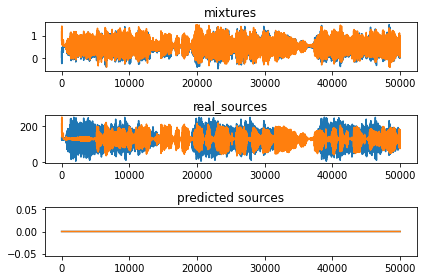

In [54]:
sampling_rate, mix1 = wavfile.read('mix1.wav')
sampling_rate, mix2 = wavfile.read('mix2.wav')
sampling_rate, source1 = wavfile.read('source1.wav')
sampling_rate, source2 = wavfile.read('source2.wav')
X = mix_sources([mix1, mix2])
S = ica(X, iterations=1000)

plot_mixture_sources_prediction(X, [source1, source2], S)

wavfile.write('out1.wav', sampling_rate, S[0])
wavfile.write('out2.wav', sampling_rate, S[1])


### Sklearn

#### Finally we take a look at how could go about acheieving the same result using the scikit-learn implementation of ICA

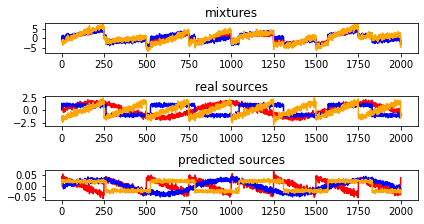

In [62]:
from sklearn.decomposition import FastICA
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time)

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)
S /= S.std(axis=0)
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])
X = np.dot(S, A.T)

ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)

fig = plt.figure()

models = [X, S, S_]

names = ['mixtures', 'real sources', 'predicted sources']
colors = ['red', 'blue', 'orange']

for i, (name, model) in enumerate(zip(names, models)):
  plt.subplot(4, 1, i+1)
  plt.title(name)
  for sig, color in zip(model.T, colors):
    plt.plot(sig, color=color)

fig.tight_layout()
plt.show()
